In [1]:
!date

Fri Jul 30 10:17:46 PDT 2021


# Class DE isoform hidden by gene

In [2]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')


import sys
sys.path.append('../../../BYVSTZP_2020/dexpress')
from dexpress import dexpress, utils, plot

#sys.path.append('../../../BYVSTZP_2020/trackfig')
#from trackfig.utils import get_notebook_name
#from trackfig.trackfig import trackfig 

#TRACKFIG = "../../../BYVSTZP_2020/trackfig.txt"
#NB = get_notebook_name()

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

/home/nmarkari/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [3]:
subclass_cmap = pd.read_csv('../metadata_files/CTX_Hip_anno_SSv4.csv', index_col='cluster_label',usecols=['cluster_label','cluster_color'])
subclass_cmap = subclass_cmap.drop_duplicates()
subclass_cmap = subclass_cmap.cluster_color.apply(lambda x: mcolors.to_rgb(x) )
subclass_cmap = subclass_cmap.to_dict()

In [4]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [5]:
gene = anndata.read_h5ad("../../data/notebook/revision/gene.h5ad")
struct_dict = {
    "ACA": "CTX",
    "AI": "CTX",
    "ALM": "CTX",
    "AUD": "CTX",
    "ENT": "HPF",
    "ENTl": "HPF",
    "ENTm": "HPF",
    "GU-VISC-AIp": "CTX",
    "HIP": "HPF",
    "MOp": "CTX",
    "MOs-FRP": "CTX",
    "ORB": "CTX",
    "PAR-POST-PRE": "HPF",
    "PAR-POST-PRE-SUB-ProS": "HPF",
    "PL-ILA": "CTX",
    "PL-ILA-ORB": "CTX",
    "PTLp": "CTX", 
    "RSP": "CTX",
    "RSPv": "CTX",
    "SSp": "CTX",
    "SSs": "CTX",
    "SSs-GU-VISC-AIp": "CTX",
    "SUB-ProS": "HPF",
    "TEa-PERI-ECT": "CTX",
    "VIS": "CTX",
    "VISpl-VISpor": "CTX",
    "VISl-VISal-VISli": "CTX",
    "VISam-VISpm": "CTX",
    "VISl": "CTX",
    "VISm": "CTX",
    "VISp": "CTX",
}
gene.obs['struct_label']=gene.obs["region_label"].map(struct_dict)
gene.obs.struct_label.value_counts()

HPF    10905
CTX     7270
Name: struct_label, dtype: int64

In [6]:
isoform = anndata.read_h5ad("../../data/notebook/revision/isoform.h5ad")
isoform.obs['struct_label']=isoform.obs["region_label"].map(struct_dict)

In [7]:
isoform = isoform[:,isoform.var.sort_values("gene_id").index]
gene = gene[:,gene.var.sort_values("gene_id").index]

In [8]:
isoform = isoform[isoform.obs.eval("subclass_label != 'L5 IT'").values]
gene = gene[gene.obs.eval("subclass_label != 'L5 IT'").values]

In [9]:
print(isoform.shape)
print(gene.shape)

(18175, 81527)
(18175, 26154)


In [10]:
gene.obs

,cell_id,cluster_id,cluster_label,subclass_id,subclass_label,region_label,class_label,cluster_color,class_id,cell_counts,percent_mito,n_genes,pass_count_filter,leiden,louvain,struct_label
0,SM-GE5TN_S001_E1-50,345,345_CA1,1,CA1-ProS,HIP,Glutamatergic,#680DFF,1,286.215515,2.001043,11329,True,5,6,HPF
1,SM-GE5TN_S002_E1-50,362,362_DG,6,DG,HIP,Glutamatergic,#3447B9,1,295.613159,2.276559,8265,True,0,0,HPF
2,SM-GE5TN_S003_E1-50,333,333_CA1-ProS,1,CA1-ProS,HIP,Glutamatergic,#8274BF,1,275.008270,1.412877,10184,True,5,6,HPF
3,SM-GE5TN_S004_E1-50,330,330_CA1-ProS,1,CA1-ProS,HIP,Glutamatergic,#8883C0,1,312.885132,1.964671,10989,True,5,6,HPF
4,SM-GE5TN_S005_E1-50,337,337_CA1,1,CA1-ProS,HIP,Glutamatergic,#A68CFF,1,350.497681,1.713655,9950,True,5,6,HPF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1690-1,SM-GE8ZJ_S302_E1-50,223,223_L6 IT CTX,23,L6 IT CTX,RSP,Glutamatergic,#7F833B,1,471.582245,3.387203,9588,True,12,3,CTX
1691-1,SM-GE8ZJ_S303_E1-50,166,166_L2/3 IT CTX,10,L2/3 IT CTX,RSP,Glutamatergic,#00FF34,1,493.948547,3.096424,10044,True,6,7,CTX
1692-1,SM-GE8ZJ_S304_E1-50,193,193_L4/5 IT CTX,16,L4/5 IT CTX,RSP,Glutamatergic,#58D2C1,1,563.157471,3.218479,9089,True,11,3,CTX
1693-1,SM-GE91P_S383_E1-50,168,168_L2/3 IT CTX,10,L2/3 IT CTX,RSP,Glutamatergic,#02F970,1,372.662445,3.144827,9743,True,6,7,CTX


In [11]:
mask = np.logical_or(gene.obs.class_label == "GABAergic", gene.obs.class_label == "Glutamatergic")
m_gene = gene[mask]
m_gene.obs.cluster_label.value_counts()

363_DG                     1840
348_CA1-do                  486
191_L4/5 IT CTX             404
168_L2/3 IT CTX             385
133_L2 IT RSPv-POST-PRE     384
                           ... 
306_L6b CTX                   1
264_L5/6 NP CTX               1
217_L6 IT CTX                 1
218_L6 IT CTX                 1
65_Sst Chodl                  1
Name: cluster_label, Length: 336, dtype: int64

In [12]:
structs = gene.obs.struct_label.unique()
clusters = gene.obs.cluster_label.unique()
breakdown = pd.DataFrame(index=clusters, columns=structs)
for struct in structs:
    m = gene.obs.struct_label == struct
    r = gene.obs[m]
    d = r.cluster_label.value_counts()
    d = d.to_dict()
    breakdown[struct] = breakdown.index.map(d)
c = 2 #minimum number of columns that must satisfy criteria
n = 50 #minimum number of cells
b = breakdown.applymap(lambda x: x >=n)
for struct in structs:
    b[struct] = b[struct].map({True:1,False:0})
m2 = b.sum(axis=1) >= c
f_breakdown =breakdown[m2]
f_breakdown

,HPF,CTX
12_Lamp5,94,167
11_Lamp5,55,65
51_Vip,183,157


In [13]:
def gene_dexpress(c_gene):
    mat           = c_gene.layers["log1p"].todense()
    components    = c_gene.obs.cell_id.values
    features      = c_gene.var.gene_name.values
    assignments   = c_gene.obs.struct_label.values

    unique = np.unique(assignments)
    nan_cutoff = 0.9 # of elements in cluster
    corr_method = "bonferroni"


    p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
    p_raw = p_raw/2
    p_corr = utils.correct_pval(p_raw, nfeat, corr_method)

    s = stat

    markers_gene = dexpress.make_table(assignments, features, p_raw, p_corr, es)

    # convert the 0 pvalues to the smallest possible float
    markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min
    markers_gene = markers_gene.query("es > 0")
    return markers_gene

In [14]:
def isoform_dexpress(c_isoform):
    mat         = c_isoform.layers["log1p"].todense() # expects dense matrix
    components  = c_isoform.obs.cell_id.values
    features    = c_isoform.var.transcript_name.values
    assignments = c_isoform.obs.struct_label.values

    unique = np.unique(assignments)
    nan_cutoff = 0.9 # of elements in cluster
    corr_method = "bonferroni"


    p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
    p_raw = p_raw/2
    p_corr = dexpress.correct_pval(p_raw, nfeat, corr_method)

    s = stat

    markers_isoform = dexpress.make_table(assignments, features, p_raw, p_corr, es)

    # convert the 0 pvalues to the smallest possible float
    markers_isoform["p_corr"][markers_isoform.eval("p_corr == 0").values] = sys.float_info.min
    markers_isoform = markers_isoform.query("es > 0")
    return markers_isoform

In [15]:
f_breakdown.index

CategoricalIndex(['12_Lamp5', '11_Lamp5', '51_Vip'], categories=['345_CA1', '362_DG', '333_CA1-ProS', '330_CA1-ProS', '337_CA1', '342_CA1', '344_CA1', '363_DG', ...], ordered=False, dtype='category')

In [16]:
markers_gene = pd.DataFrame(columns=['index','name','p_raw','p_corr','es','index_name','cluster'])
markers_isoform = pd.DataFrame(columns=['index','name','p_raw','p_corr','es','index_name','cluster'])
for cluster in f_breakdown.index:
    mask = np.logical_and(gene.obs.cluster_label==cluster ,np.logical_or(gene.obs.class_label == "GABAergic", gene.obs.class_label == "Glutamatergic"))

    c_gene = gene[mask]
    c_isoform = isoform[mask]
    temp_gene = gene_dexpress(c_gene)
    temp_gene['cluster'] = cluster
    markers_gene = pd.concat([markers_gene,temp_gene])
    temp_isoform = isoform_dexpress(c_isoform)
    temp_isoform['cluster'] = cluster
    markers_isoform = pd.concat([markers_isoform,temp_isoform])
    

30-Jul-21 10:18:17 - 1 of 2 assignments: CTX
30-Jul-21 10:18:17 - 2 of 2 assignments: HPF
30-Jul-21 10:18:18 - 1 of 2 assignments: CTX
30-Jul-21 10:18:18 - 2 of 2 assignments: HPF
30-Jul-21 10:18:19 - 1 of 2 assignments: CTX
30-Jul-21 10:18:19 - 2 of 2 assignments: HPF
30-Jul-21 10:18:19 - 1 of 2 assignments: CTX
30-Jul-21 10:18:19 - 2 of 2 assignments: HPF
30-Jul-21 10:18:19 - 1 of 2 assignments: CTX
30-Jul-21 10:18:19 - 2 of 2 assignments: HPF
30-Jul-21 10:18:20 - 1 of 2 assignments: CTX
30-Jul-21 10:18:20 - 2 of 2 assignments: HPF


In [17]:
#mask = np.logical_and(gene.obs.subclass_label == 'Vip', np.logical_or(gene.obs.class_label == "Glutamatergic", gene.obs.class_label == "GABAergic"))
#mask = (gene.obs.subclass_label == 'Vip')

#c_gene = gene[mask]
#c_isoform = isoform[mask]
#markers_gene= gene_dexpress(c_gene)
#markers_isoform = isoform_dexpress(c_isoform)

# Want to make a mask to return the isoforms for which the isoform is differential but the gene is not

In [18]:
alpha =0.01/len(f_breakdown.index) #second bonferroni correction for multiple clusters being tested
fc = 2

relevant_genes = markers_gene.p_corr < alpha

markers_gene["index_name"] = markers_gene["index"] + "_" + markers_gene.name.apply(lambda x: "".join(x.split("_")[:-1])) + "_"+ markers_gene["cluster"]
markers_isoform["index_name"] = markers_isoform["index"] + "_" + markers_isoform.name.apply(lambda x: "-".join(x.split("-")[:-1])) + "_"+ markers_isoform["cluster"]

setdiff = np.setdiff1d(markers_isoform["index_name"].values, markers_gene[relevant_genes]["index_name"].values)

In [19]:
markers_isoform = markers_isoform[markers_isoform["index_name"].isin(setdiff)].sort_values(["es", "p_corr"])

markers_isoform = markers_isoform.query(f"p_corr < {alpha}")
markers_isoform.sort_values("es")[::-1][:20]

,index,name,p_raw,p_corr,es,index_name,cluster
116604,HPF,Tsc22d3-202_ENSMUST00000112995.3,6.34159e-07,0.00202741,1.4375,HPF_Tsc22d3_11_Lamp5,11_Lamp5
117968,HPF,Aplp2-201_ENSMUST00000072634.15,6.22591e-07,0.00180738,1.134,HPF_Aplp2_12_Lamp5,12_Lamp5
137063,HPF,Morn4-201_ENSMUST00000051772.10,5.09681e-07,0.0014796,1.01161,HPF_Morn4_12_Lamp5,12_Lamp5
112036,HPF,Tmem165-201_ENSMUST00000031144.14,2.7723e-07,0.000804798,1,HPF_Tmem165_12_Lamp5,12_Lamp5
94435,HPF,Habp4-201_ENSMUST00000021929.10,3.50357e-07,0.00055041,0.982432,HPF_Habp4_51_Vip,51_Vip
3467,CTX,Syt5-202_ENSMUST00000206023.2,3.24342e-08,4.79378e-05,0.97667,CTX_Syt5_51_Vip,51_Vip
82685,HPF,Chordc1-208_ENSMUST00000217031.2,4.94014e-07,0.00143412,0.927494,HPF_Chordc1_12_Lamp5,12_Lamp5
139854,HPF,Set-201_ENSMUST00000067996.7,1.13878e-08,1.78902e-05,0.773646,HPF_Set_51_Vip,51_Vip
88609,HPF,Sqstm1-201_ENSMUST00000015981.12,5.50588e-07,0.00159836,0.675003,HPF_Sqstm1_12_Lamp5,12_Lamp5
98097,HPF,App-201_ENSMUST00000005406.12,1.13109e-07,0.000328355,0.658653,HPF_App_12_Lamp5,12_Lamp5


In [20]:
markers_gene[markers_gene.name.str.contains("Kif1b")]
#markers_gene[markers_gene.name.str.contains("Kifap")]

,index,name,p_raw,p_corr,es,index_name,cluster
39570,HPF,Kif1b_ENSMUSG00000063077.16,2.26932e-05,0.0725957,0.396568,HPF_Kif1b_12_Lamp5,12_Lamp5
13416,CTX,Kif1b_ENSMUSG00000063077.16,0.45781,1,0.0153717,CTX_Kif1b_11_Lamp5,11_Lamp5
39570,HPF,Kif1b_ENSMUSG00000063077.16,0.0233083,1,0.268892,HPF_Kif1b_51_Vip,51_Vip


In [21]:
isoform.var.transcript_name[isoform.var.transcript_name.str.contains("Oxr1")]

Oxr1-213_ENSMUST00000230131.2      Oxr1-213_ENSMUST00000230131.2
Oxr1-211_ENSMUST00000230126.2      Oxr1-211_ENSMUST00000230126.2
Oxr1-203_ENSMUST00000090096.11    Oxr1-203_ENSMUST00000090096.11
Oxr1-215_ENSMUST00000230778.2      Oxr1-215_ENSMUST00000230778.2
Oxr1-209_ENSMUST00000229769.2      Oxr1-209_ENSMUST00000229769.2
Oxr1-204_ENSMUST00000110297.10    Oxr1-204_ENSMUST00000110297.10
Oxr1-202_ENSMUST00000090095.13    Oxr1-202_ENSMUST00000090095.13
Oxr1-212_ENSMUST00000230127.2      Oxr1-212_ENSMUST00000230127.2
Oxr1-214_ENSMUST00000230203.2      Oxr1-214_ENSMUST00000230203.2
Oxr1-210_ENSMUST00000229836.2      Oxr1-210_ENSMUST00000229836.2
Oxr1-205_ENSMUST00000166917.3      Oxr1-205_ENSMUST00000166917.3
Oxr1-216_ENSMUST00000231215.2      Oxr1-216_ENSMUST00000231215.2
Oxr1-207_ENSMUST00000179393.8      Oxr1-207_ENSMUST00000179393.8
Oxr1-206_ENSMUST00000170127.9      Oxr1-206_ENSMUST00000170127.9
Oxr1-201_ENSMUST00000022918.15    Oxr1-201_ENSMUST00000022918.15
Oxr1-208_ENSMUST000002295

In [22]:
isoform

View of AnnData object with n_obs × n_vars = 18175 × 81527
    obs: 'cell_id', 'cluster_id', 'cluster_label', 'subclass_id', 'subclass_label', 'region_label', 'class_label', 'cluster_color', 'class_id', 'cell_counts', 'leiden', 'louvain', 'struct_label'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'gene_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'log1p', 'norm', 'raw', 'scaled'
    obsp: 'connectivities', 'distances'

In [23]:
#specific_cluster = "Glutamatergic"
#specific_gene = "Kifap3_ENSMUSG00000026585.14"
#specific_isoform = "Kifap3-202_ENSMUST00000077642.12"

#specific_cluster = "ENTl"
specific_struct = "CTX"
specific_gene = "Oxr1_ENSMUSG00000022307.17"
specific_isoform = "Oxr1-203_ENSMUST00000090096.11"
specific_cluster = '49_Vip'

In [24]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    selected = kwd.get("selected", None)
    color = kwd.get("color", "grey")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
        if selected == vidx:
            v.set_facecolor("#D43F3A")

            
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 5, color="white", edgecolor="black", linewidth=1)
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean, color="lightgrey", edgecolor="black", linewidth=1, zorder=10)    
        ax.vlines(x, mean - stdev, mean+stdev, color='lightgrey', linestyle='-', lw=2, zorder=9)
        
    ax.set(**{"xticks": xticks, "xticklabels":xticklabels})
    
    return ax


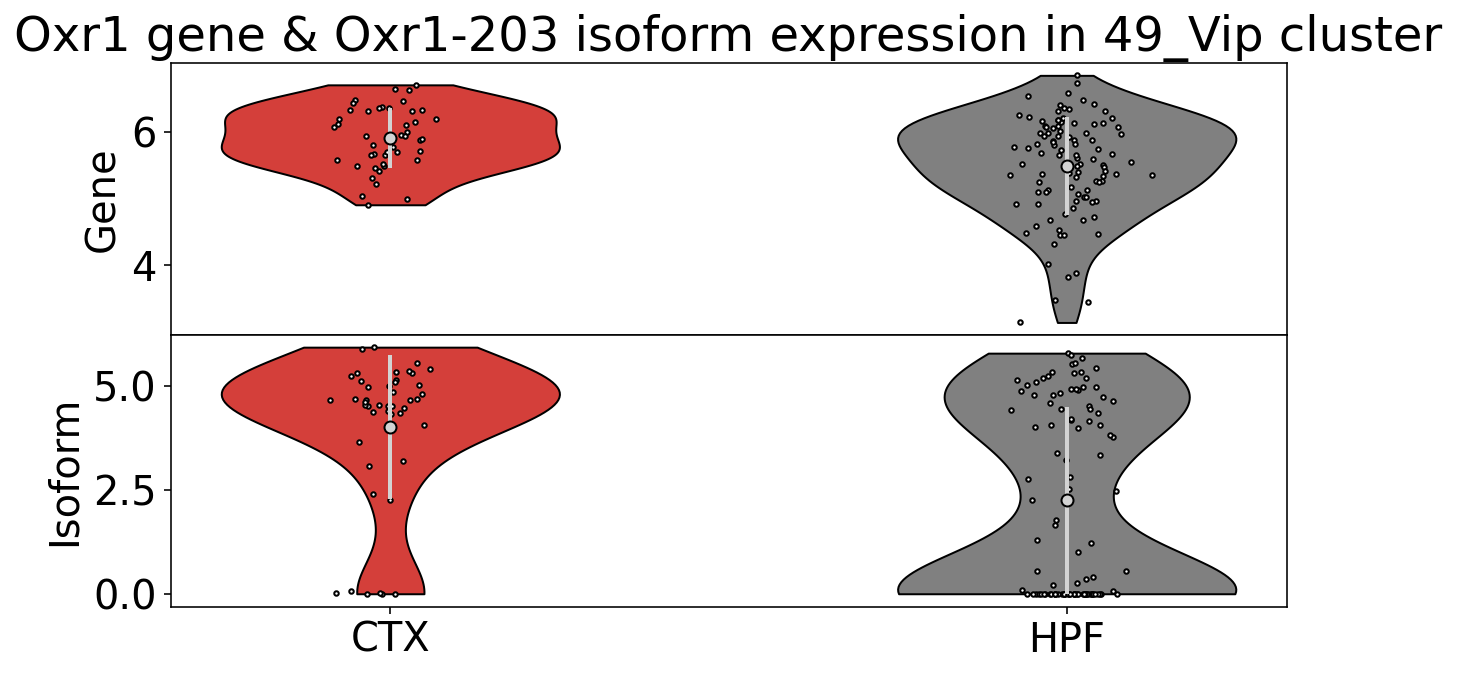

In [25]:
fig, ax = plt.subplots(figsize=(10,5), nrows=2, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

mask = np.logical_and(gene.obs.cluster_label == specific_cluster, np.logical_or(gene.obs.class_label == "Glutamatergic", gene.obs.class_label == "GABAergic"))
c_gene = gene[mask]
c_isoform = isoform[mask]
# Declare
unique = np.unique(c_gene.obs.struct_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))
unique = np.delete(unique, np.where(unique=="Non-Neuronal"))
labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_struct)[0][0] #todo

## Plot
# Gene
x = []
for c in unique:
    x.append(np.asarray(c_gene[c_gene.obs.struct_label==c][:,c_gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[0], selected=midx)

# Isoform
x = []
for c in unique:
    x.append(np.asarray(c_isoform[c_isoform.obs.struct_label==c][:,c_isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[1], selected=midx, xticks=lidx, xticklabels=labels)
## Style
ax[0].set(**{
    "title":"{} gene & {} isoform expression in {} cluster".format(specific_gene.split("_")[0], specific_isoform.split("_")[0],specific_cluster),
    "ylabel":"Gene",
})

#need to figure out what ax[0] and ax[1] are
ymin, ymax = ax[1].get_ylim()
ax[1].set(**{
    "ylabel":"Isoform",
    "ylim": (ymin, ymax),
})

plt.savefig("../../figures/struct_cluster_DE_violin_all.png", bbox_inches='tight',dpi=300)
plt.show()

# gene.obs

In [26]:
#c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
isoform[:, isoform.var.transcript_name==specific_isoform]

View of AnnData object with n_obs × n_vars = 18175 × 1
    obs: 'cell_id', 'cluster_id', 'cluster_label', 'subclass_id', 'subclass_label', 'region_label', 'class_label', 'cluster_color', 'class_id', 'cell_counts', 'leiden', 'louvain', 'struct_label'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'gene_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'log1p', 'norm', 'raw', 'scaled'
    obsp: 'connectivities', 'distances'

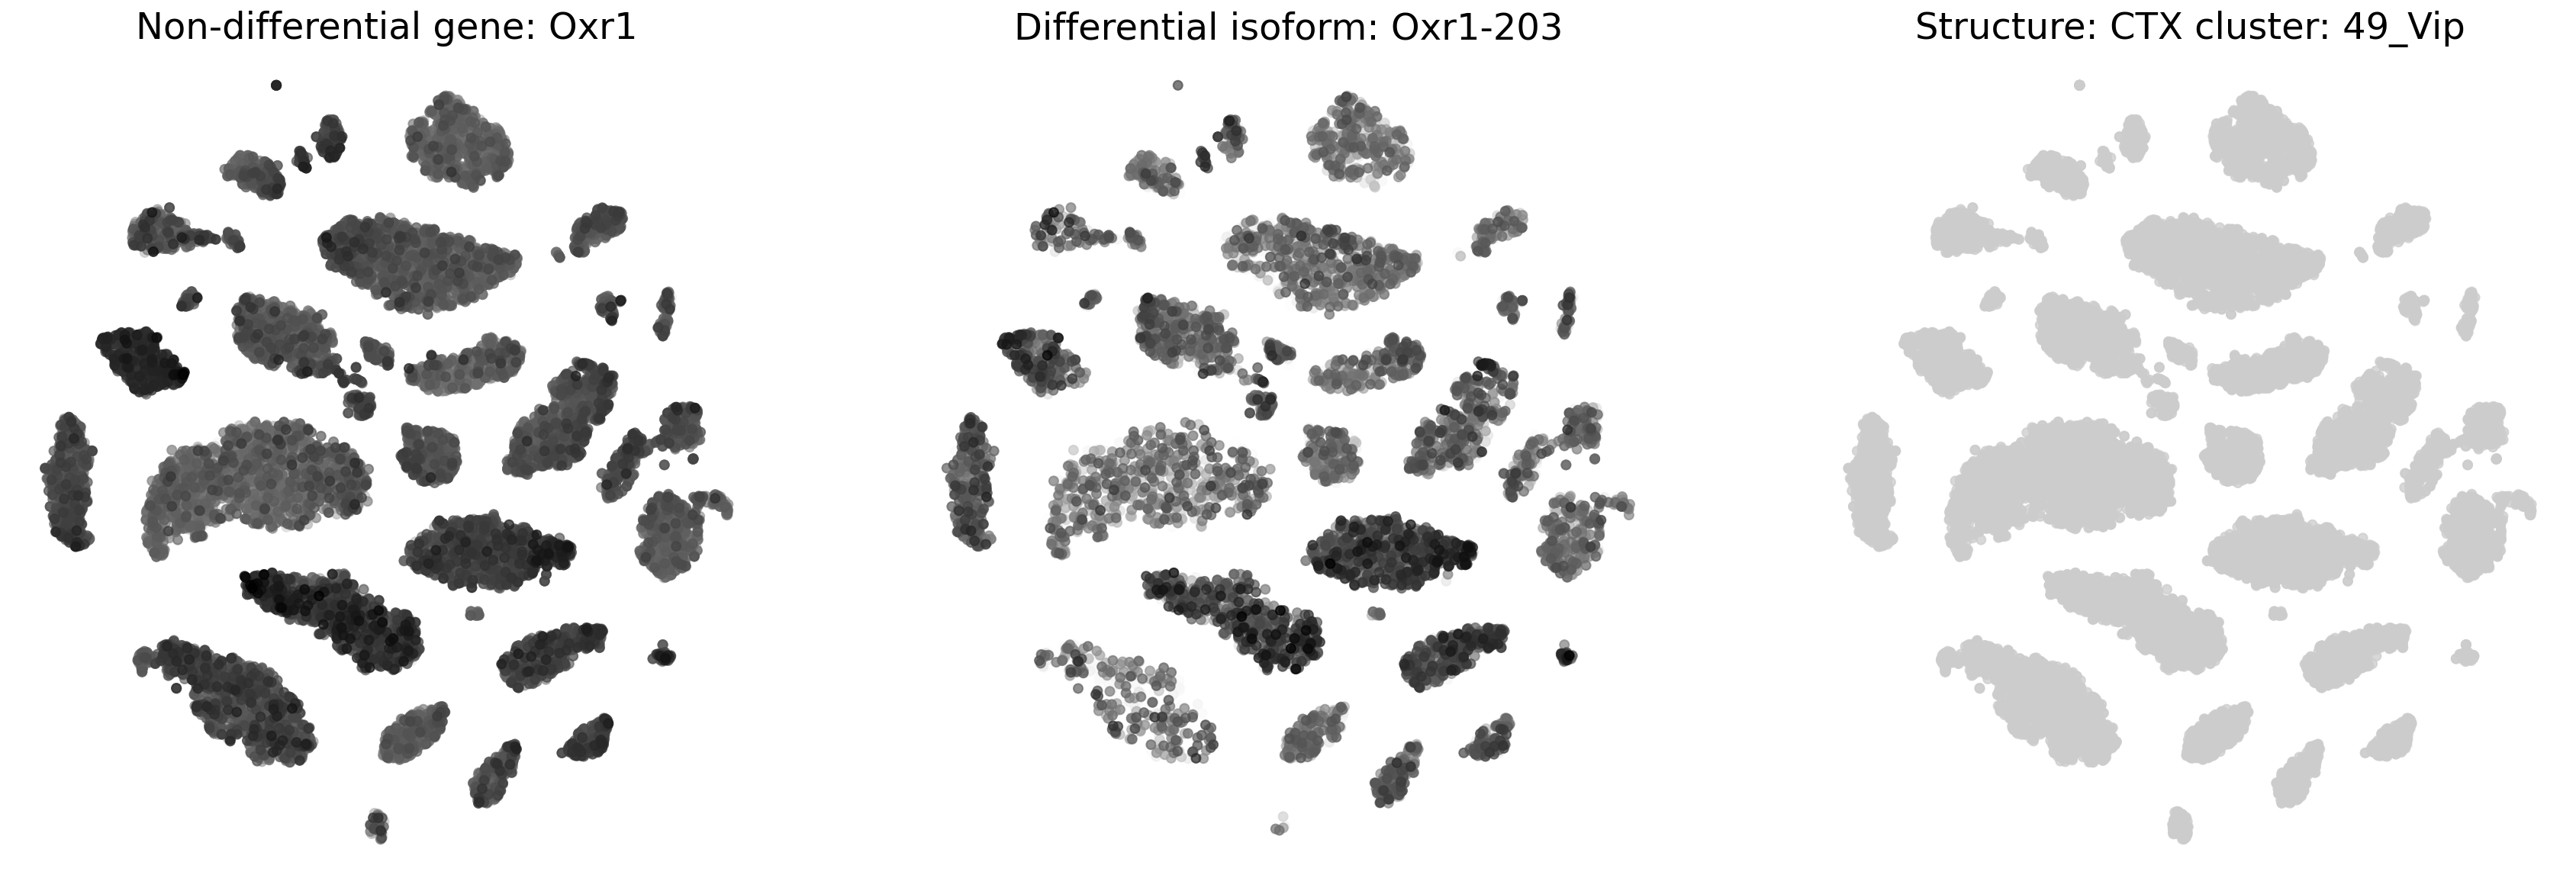

In [27]:
#this figure doesnt really make sense to use
complement_color = (0.8, 0.8, 0.8, 1.0)

fig, ax = plt.subplots(figsize=(30,10), ncols=3)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(gene[:, gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1)
argsort = np.argsort(c)
x = x[argsort]
y = y[argsort]
c = c[argsort]
cmap="Greys"
alpha = 0.75
ax[0].set_title("Non-differential gene: {}".format(specific_gene.split("_")[0]))

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()


x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
argsort = np.argsort(c)
x = x[argsort]
y = y[argsort]
c = c[argsort]
cmap="Greys"
alpha = 0.75
ax[1].set_title("Differential isoform: {}".format(specific_isoform.split("_")[0]))

ax[1].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[1].set_axis_off()

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = gene.obs["cluster_label"]==specific_cluster
c = gene.obs["cluster_label"].astype(str).map(subclass_cmap).tolist()
indices = np.where(np.logical_or(gene.obs["struct_label"]!=specific_cluster, gene.obs["cluster_label"]!=specific_cluster))[0]
replacements=[complement_color]*len(indices)
for (index, replacement) in zip(indices, replacements):
    c[index] = replacement
alpha=0.75
cmap="nipy_spectral_r"

ax[2].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[2].set_axis_off()
ax[2].set_title("Structure: {} cluster: {}".format(specific_struct, specific_cluster))
plt.savefig("../../figures/class_DE_nca_all.png", bbox_inches='tight',dpi=300)
plt.show()

In [28]:
identified_isoforms = markers_isoform["name"].explode().astype(str)

In [29]:
identified_genes = identified_isoforms.apply(lambda x: x.split("-")[0:-1][0])

In [30]:
print("{} isoforms from {} genes identified.".format(identified_isoforms.shape[0], identified_genes.nunique()))

34 isoforms from 29 genes identified.


In [31]:
markers_isoform.to_csv("../../tables/unordered/struct_cluster_DE.csv")